In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

parent_path = os.path.abspath('..')
if parent_path not in sys.path:
    sys.path.append(parent_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from lib.calendar import get_market_calendar
from lib.utils import is_business_day
from lib.exog_data import get_yfinance_data
from lib.windows import get_train_test_index

$$
\hat{\Delta \ln(USD\_CLP_{t+i})} =
f(\mathbf{X}_{t-j}, \boldsymbol{\theta}_i) + \varepsilon_t,
\quad \text{donde } i \in \{1, 2, 3\}, \, j \in \{0, 1, 2\}.
$$

$where$

$$\Delta \ln(USD\_CLP_{t+i}) \equiv \ln(USD\_CLP_{t+i}) - \ln(USD\_CLP_{t+i-1}),$$

$\text{y cada } \boldsymbol{\theta}_i \text{ corresponde a modelos independientes para cada horizonte de predicción (} t+i \text{).}$ 

### Market Calendar

In [4]:
market_calendar = get_market_calendar("CME_Currency", ["2016-12-30", "2024-10-30"])
market_calendar[:16]

DatetimeIndex(['2016-12-30', '2017-01-03', '2017-01-04', '2017-01-05',
               '2017-01-06', '2017-01-09', '2017-01-10', '2017-01-11',
               '2017-01-12', '2017-01-13', '2017-01-16', '2017-01-17',
               '2017-01-18', '2017-01-19', '2017-01-20', '2017-01-23'],
              dtype='datetime64[ns]', freq='C')

### Exchange Rate

In [5]:
df_exchange_rate = pd.read_csv("../data/raw/exchangeRateIATA.csv", sep=";")
df_exchange_rate["dates"] = pd.to_datetime(df_exchange_rate["dates"])
df_exchange_rate = df_exchange_rate.sort_values(by="dates", ascending=True).reset_index(drop=True)

df_exchange_rate.rename(columns={"iata":"usd_clp"}, inplace=True)

# En la base original existen cambios de precio los días sabado, lo que es imposible por las características del mercado.
# Se asume error en las fechas y se rezaga -1 periodo para corregir
#df_exchange_rate["usd_clp"] = df_exchange_rate["usd_clp"].shift(-1)


# Mantener los días no hábiles en la base propagando el último valor válido introducirá error en cálculo de estimadores.
# Se utiliza calendario de mercado cambiario para determinar los dias hábiles.
df_exchange_rate["dummy_bd"] = df_exchange_rate["dates"].apply(lambda x: is_business_day(x, market_calendar))
df_exchange_rate = df_exchange_rate.query("dummy_bd == 1").reset_index(drop=True)
df_exchange_rate.drop("dummy_bd", axis=1, inplace=True)

df_exchange_rate["usd_clp_t-1"] = df_exchange_rate["usd_clp"].shift(1)
df_exchange_rate["usd_clp_t+1"] = df_exchange_rate["usd_clp"].shift(-1)
df_exchange_rate["usd_clp_t+2"] = df_exchange_rate["usd_clp"].shift(-2)
df_exchange_rate["usd_clp_t+3"] = df_exchange_rate["usd_clp"].shift(-3)


# Se calcula primera diferencia para convertir la serie a estacionaria
df_exchange_rate["y_t+0"] = np.log(df_exchange_rate["usd_clp_t-1"]) - np.log(df_exchange_rate["usd_clp"])
df_exchange_rate["y_t-1"] = df_exchange_rate["y_t+0"].shift(1)
df_exchange_rate["y_t-2"] = df_exchange_rate["y_t+0"].shift(2)
df_exchange_rate["y_t+1"] = np.log(df_exchange_rate["usd_clp_t+1"]) - np.log(df_exchange_rate["usd_clp"])
df_exchange_rate["y_t+2"] = np.log(df_exchange_rate["usd_clp_t+2"]) - np.log(df_exchange_rate["usd_clp"])
df_exchange_rate["y_t+3"] = np.log(df_exchange_rate["usd_clp_t+3"]) - np.log(df_exchange_rate["usd_clp"])

df_exchange_rate.tail()

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3
2015,2024-10-18,940,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784
2016,2024-10-21,942,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509
2017,2024-10-22,954,942.0,954.0,951.0,NaN,-0.012658,-0.002125,-0.007475,0.000000,-0.003150,NaN
2018,2024-10-23,954,954.0,951.0,NaN,NaN,0.000000,-0.012658,-0.002125,-0.003150,NaN,NaN
2019,2024-10-24,951,954.0,NaN,NaN,NaN,0.003150,0.000000,-0.012658,NaN,NaN,NaN


### Copper Prices

In [6]:
df_copper = get_yfinance_data(ticker_symbol="HG=F", date_interval=["2016-12-30", "2024-10-30"], name="copper")
df_copper.head(5)

,dates,copper_close
0,2016-12-30,2.4975
1,2017-01-03,2.4810
2,2017-01-04,2.5480
3,2017-01-05,2.5295
4,2017-01-06,2.5380


In [7]:
df_copper["copper_close"] = df_copper["copper_close"].shift(-1)

In [8]:
df = df_exchange_rate.merge(df_copper, how="left", on="dates")
df.tail(14)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close
2006,2024-10-07,916,907.0,925.0,926.0,930.0,-0.009874,-0.003313,-0.004435,0.009777,0.010858,0.015168,4.4120
2007,2024-10-08,925,916.0,926.0,930.0,934.0,-0.009777,-0.009874,-0.003313,0.001080,0.005391,0.009683,4.3550
2008,2024-10-09,926,925.0,930.0,934.0,932.0,-0.001080,-0.009777,-0.009874,0.004310,0.008602,0.006459,4.3850
2009,2024-10-10,930,926.0,934.0,932.0,927.0,-0.004310,-0.001080,-0.009777,0.004292,0.002148,-0.003231,4.4515
2010,2024-10-11,934,930.0,932.0,927.0,928.0,-0.004292,-0.004310,-0.001080,-0.002144,-0.007523,-0.006445,4.3635
2011,2024-10-14,932,934.0,927.0,928.0,933.0,0.002144,-0.004292,-0.004310,-0.005379,-0.004301,0.001072,4.3005
2012,2024-10-15,927,932.0,928.0,933.0,940.0,0.005379,0.002144,-0.004292,0.001078,0.006452,0.013926,4.3315
2013,2024-10-16,928,927.0,933.0,940.0,942.0,-0.001078,0.005379,0.002144,0.005373,0.012848,0.014974,4.2865
2014,2024-10-17,933,928.0,940.0,942.0,954.0,-0.005373,-0.001078,0.005379,0.007475,0.009600,0.022258,4.3460
2015,2024-10-18,940,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.3230


In [9]:
# Imputar nulos precio cobre con promedio entr t-1 y t+1
df['copper_close'] = df['copper_close'].fillna((df['copper_close'].shift(1) + df['copper_close'].shift(-1)) / 2)

In [10]:
df.tail(14)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close
2006,2024-10-07,916,907.0,925.0,926.0,930.0,-0.009874,-0.003313,-0.004435,0.009777,0.010858,0.015168,4.4120
2007,2024-10-08,925,916.0,926.0,930.0,934.0,-0.009777,-0.009874,-0.003313,0.001080,0.005391,0.009683,4.3550
2008,2024-10-09,926,925.0,930.0,934.0,932.0,-0.001080,-0.009777,-0.009874,0.004310,0.008602,0.006459,4.3850
2009,2024-10-10,930,926.0,934.0,932.0,927.0,-0.004310,-0.001080,-0.009777,0.004292,0.002148,-0.003231,4.4515
2010,2024-10-11,934,930.0,932.0,927.0,928.0,-0.004292,-0.004310,-0.001080,-0.002144,-0.007523,-0.006445,4.3635
2011,2024-10-14,932,934.0,927.0,928.0,933.0,0.002144,-0.004292,-0.004310,-0.005379,-0.004301,0.001072,4.3005
2012,2024-10-15,927,932.0,928.0,933.0,940.0,0.005379,0.002144,-0.004292,0.001078,0.006452,0.013926,4.3315
2013,2024-10-16,928,927.0,933.0,940.0,942.0,-0.001078,0.005379,0.002144,0.005373,0.012848,0.014974,4.2865
2014,2024-10-17,933,928.0,940.0,942.0,954.0,-0.005373,-0.001078,0.005379,0.007475,0.009600,0.022258,4.3460
2015,2024-10-18,940,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.3230


In [11]:
df["copper_t+0"] = np.log(df["copper_close"]) - np.log(df["copper_close"].shift())
df["copper_t-1"] = df["copper_t+0"].shift(1)
df["copper_t-2"] = df["copper_t+0"].shift(2)
df["copper_t-3"] = df["copper_t+0"].shift(3)
df["copper_t-4"] = df["copper_t+0"].shift(4)
df["copper_t-5"] = df["copper_t+0"].shift(5)

df.head(6)

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
0,2017-01-03,670,NaN,675.0,674.0,675.0,NaN,NaN,NaN,0.007435,0.005952,0.007435,2.5480,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-04,675,670.0,674.0,675.0,668.0,-0.007435,NaN,NaN,-0.001483,0.000000,-0.010425,2.5295,-0.007287,NaN,NaN,NaN,NaN,NaN
2,2017-01-05,674,675.0,675.0,668.0,668.0,0.001483,-0.007435,NaN,0.001483,-0.008942,-0.008942,2.5380,0.003355,-0.007287,NaN,NaN,NaN,NaN
3,2017-01-06,675,674.0,668.0,668.0,668.0,-0.001483,0.001483,-0.007435,-0.010425,-0.010425,-0.010425,2.5300,-0.003157,0.003355,-0.007287,NaN,NaN,NaN
4,2017-01-09,668,675.0,668.0,668.0,670.0,0.010425,-0.001483,0.001483,0.000000,0.000000,0.002990,2.6035,0.028637,-0.003157,0.003355,-0.007287,NaN,NaN
5,2017-01-10,668,668.0,668.0,670.0,678.0,0.000000,0.010425,-0.001483,0.000000,0.002990,0.014859,2.6010,-0.000961,0.028637,-0.003157,0.003355,-0.007287,NaN


In [12]:
df.dropna(subset=["usd_clp","copper_t-5"], inplace=True)
df.reset_index(inplace=True, drop=True)

In [13]:
df.head()

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
0,2017-01-11,668,668.0,670.0,678.0,672.0,0.000000,0.000000,0.010425,0.002990,0.014859,0.005970,2.66050,0.022618,-0.000961,0.028637,-0.003157,0.003355,-0.007287
1,2017-01-12,670,668.0,678.0,672.0,660.0,-0.002990,0.000000,0.000000,0.011870,0.002981,-0.015038,2.68050,0.007489,0.022618,-0.000961,0.028637,-0.003157,0.003355
2,2017-01-13,678,670.0,672.0,660.0,661.0,-0.011870,-0.002990,0.000000,-0.008889,-0.026907,-0.025393,2.61650,-0.024166,0.007489,0.022618,-0.000961,0.028637,-0.003157
3,2017-01-16,672,678.0,660.0,661.0,661.0,0.008889,-0.011870,-0.002990,-0.018019,-0.016505,-0.016505,2.61225,-0.001626,-0.024166,0.007489,0.022618,-0.000961,0.028637
4,2017-01-17,660,672.0,661.0,661.0,659.0,0.018019,0.008889,-0.011870,0.001514,0.001514,-0.001516,2.60800,-0.001628,-0.001626,-0.024166,0.007489,0.022618,-0.000961


In [14]:
df.tail()

,dates,usd_clp,usd_clp_t-1,usd_clp_t+1,usd_clp_t+2,usd_clp_t+3,y_t+0,y_t-1,y_t-2,y_t+1,y_t+2,y_t+3,copper_close,copper_t+0,copper_t-1,copper_t-2,copper_t-3,copper_t-4,copper_t-5
2009,2024-10-18,940,933.0,942.0,954.0,954.0,-0.007475,-0.005373,-0.001078,0.002125,0.014784,0.014784,4.3230,-0.005306,0.013785,-0.010443,0.007183,-0.014543,-0.019967
2010,2024-10-21,942,940.0,954.0,954.0,951.0,-0.002125,-0.007475,-0.005373,0.012658,0.012658,0.009509,4.3480,0.005766,-0.005306,0.013785,-0.010443,0.007183,-0.014543
2011,2024-10-22,954,942.0,954.0,951.0,NaN,-0.012658,-0.002125,-0.007475,0.000000,-0.003150,NaN,4.3045,-0.010055,0.005766,-0.005306,0.013785,-0.010443,0.007183
2012,2024-10-23,954,954.0,951.0,NaN,NaN,0.000000,-0.012658,-0.002125,-0.003150,NaN,NaN,4.3195,0.003479,-0.010055,0.005766,-0.005306,0.013785,-0.010443
2013,2024-10-24,951,954.0,NaN,NaN,NaN,0.003150,0.000000,-0.012658,NaN,NaN,NaN,4.3395,0.004619,0.003479,-0.010055,0.005766,-0.005306,0.013785


In [15]:
# Calcular correlaciones y ordenar por la columna "y_t+1"
correlation_matrix = df.corr()[["y_t+1", "y_t+2", "y_t+3"]].sort_values("y_t+1")

# Crear un heatmap básico con pandas
heatmap = correlation_matrix.style.background_gradient(cmap="coolwarm").format("{:.2f}")

# Mostrar el heatmap
heatmap

,y_t+1,y_t+2,y_t+3
copper_t-2,-0.24,-0.28,-0.26
y_t+0,-0.23,-0.13,-0.10
copper_t-3,-0.19,-0.17,-0.16
copper_t-4,-0.08,-0.08,-0.08
copper_t-5,-0.05,-0.05,-0.03
copper_t-1,-0.05,-0.19,-0.25
usd_clp_t-1,-0.04,-0.05,-0.05
usd_clp,-0.02,-0.04,-0.05
copper_close,-0.01,-0.01,-0.01
copper_t+0,0.01,-0.03,-0.14


In [16]:
# no puedo considerar dias no habiles porque las primeras diferencias se vuelven 0 artificialmente y afectarán los estimadores -> se agrega condicion if not business_day = 0 

In [19]:
specs = {
    #"RW":["y_t+0"],
    #"DRW":["y_t+0"],
    #"AR(1)":["y_t+0"],
    #"AR(2)":["y_t+0", "y_t-1"],
    #"COPPER(2,1)":["y_t+0", "y_t-1", "copper_t+0"],
    #"COPPER(2,2)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1"],
    #"COPPER(2,3)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2"],
    "COPPER(2,4)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3"],
    #"COPPER(2,5)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4"],
    #"COPPER(2,6)":["y_t+0", "y_t-1", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4", "copper_t-5"],
    #"COPPER(1,1)":["y_t+0", "copper_t+0"],
    #"COPPER(1,2)":["y_t+0", "copper_t+0", "copper_t-1"],
    #"COPPER(1,3)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2"],
    #"COPPER(1,4)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3"],
    #"COPPER(1,5)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4"],
    #"COPPER(1,6)":["y_t+0", "copper_t+0", "copper_t-1", "copper_t-2", "copper_t-3", "copper_t-4", "copper_t-5"],
}

In [44]:
update_window_methods = ["rolling", "expanding"]
first_windows_ratio = [.3, .5, .7]
steps_ahead = 3

metrics = {
    "update_method":[],
    "first_windows_ratio":[],
    "scpecification":[],
    "first_train_date":[],
    "last_train_date":[],
    "step_ahead":[],
    "y":[],
    "y_pred":[],
    "sq_error":[],
    "usd_clp":[],
    "usd_clp_t":[]
}


for update_method in update_window_methods:
    for window_ratio in first_windows_ratio:
        indexes = get_train_test_index(df, ratio=window_ratio, method=update_method, steps_ahead=steps_ahead)
        
        for train_idx, test_idx in indexes:
            df_train = df.iloc[train_idx,:]
            df_test = df.iloc[test_idx,:]
            first_train_date = df_train["dates"].min()
            last_train_date = df_train["dates"].max()

            for spec_name, spec_variables in specs.items():
                X_train = df_train[spec_variables]
                X_train = X_train.dropna()

                if spec_name == "RW":
                    y_pred = np.mean(X_train)
                    for step, idx in enumerate(test_idx, start=1):
                        usd_clp = df_test.loc[idx, "usd_clp"]
                        usd_clp_t = df_test.loc[idx, f"usd_clp_t+{step}"]
                        y_test = df_test.loc[idx, f"y_t+{step}"]
                        
                        metrics["update_method"].append(update_method)
                        metrics["first_windows_ratio"].append(window_ratio)
                        metrics["scpecification"].append(spec_name)
                        metrics["first_train_date"].append(first_train_date)
                        metrics["last_train_date"].append(last_train_date)
                        metrics["step_ahead"].append(step)
                        metrics["y"].append(y_test)
                        metrics["y_pred"].append(y_pred)
                        metrics["sq_error"].append((y_pred - y_test)**2)
                        metrics["usd_clp"].append(usd_clp)
                        metrics["usd_clp_t"].append(usd_clp_t)
                        
                
                elif spec_name == "DRW":
                    y_pred = 0.0
                    for step, idx in enumerate(test_idx, start=1):
                        usd_clp = df_test.loc[idx, "usd_clp"]
                        usd_clp_t = df_test.loc[idx, f"usd_clp_t+{step}"]
                        y_test = df_test.loc[idx, f"y_t+{step}"]

                        metrics["update_method"].append(update_method)
                        metrics["first_windows_ratio"].append(window_ratio)
                        metrics["scpecification"].append(spec_name)
                        metrics["first_train_date"].append(first_train_date)
                        metrics["last_train_date"].append(last_train_date)
                        metrics["step_ahead"].append(step)
                        metrics["y"].append(y_test)
                        metrics["y_pred"].append(y_pred)
                        metrics["sq_error"].append((y_pred - y_test)**2)
                        metrics["usd_clp"].append(usd_clp)
                        metrics["usd_clp_t"].append(usd_clp_t)
                
                else:
                    for step, idx in enumerate(test_idx, start=1):
                        usd_clp = df_test.loc[idx, "usd_clp"]
                        usd_clp_t = df_test.loc[idx, f"usd_clp_t+{step}"]
                        y_train = df_train[f"y_t+{step}"]
                        
                        X_test = df_test.loc[[idx], spec_variables]
                        y_test = df_test.loc[idx, f"y_t+{step}"]
    
                        model = LinearRegression(fit_intercept=True)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)[0]
                        
                        metrics["update_method"].append(update_method)
                        metrics["first_windows_ratio"].append(window_ratio)
                        metrics["scpecification"].append(spec_name)
                        metrics["first_train_date"].append(first_train_date)
                        metrics["last_train_date"].append(last_train_date)
                        metrics["step_ahead"].append(step)
                        metrics["y"].append(y_test)
                        metrics["y_pred"].append(y_pred)
                        metrics["sq_error"].append((y_pred - y_test)**2)
                        metrics["usd_clp"].append(usd_clp)
                        metrics["usd_clp_t"].append(usd_clp_t)


In [45]:
df_results = pd.DataFrame(metrics)

In [46]:
df_results["usd_clp_t_pred"] = df_results["usd_clp"] * (1 + df_results["y_pred"])
df_results["nominal_error"] = np.abs(df_results["usd_clp_t_pred"] - df_results["usd_clp_t"])

In [47]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23'")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head()

n       mse      rmse  \
update_method first_windows_ratio scpecification                             
rolling       0.7                 COPPER(2,4)     1805  0.000167  0.012920   
expanding     0.3                 COPPER(2,4)     1808  0.000167  0.012941   
              0.5                 COPPER(2,4)     1808  0.000167  0.012941   
              0.7                 COPPER(2,4)     1805  0.000167  0.012941   
rolling       0.5                 COPPER(2,4)     1808  0.000168  0.012943   

                                                   std_dev  
update_method first_windows_ratio scpecification            
rolling       0.7                 COPPER(2,4)     0.000648  
expanding     0.3                 COPPER(2,4)     0.000646  
              0.5                 COPPER(2,4)     0.000646  
              0.7                 COPPER(2,4)     0.000647  
rolling       0.5                 COPPER(2,4)     0.000647

In [48]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23' and step_ahead == 1")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head()

n      mse      rmse  \
update_method first_windows_ratio scpecification                           
expanding     0.7                 COPPER(2,4)     603  0.00007  0.008357   
              0.3                 COPPER(2,4)     604  0.00007  0.008358   
              0.5                 COPPER(2,4)     604  0.00007  0.008358   
rolling       0.7                 COPPER(2,4)     603  0.00007  0.008367   
              0.5                 COPPER(2,4)     604  0.00007  0.008369   

                                                   std_dev  
update_method first_windows_ratio scpecification            
expanding     0.7                 COPPER(2,4)     0.000253  
              0.3                 COPPER(2,4)     0.000253  
              0.5                 COPPER(2,4)     0.000253  
rolling       0.7                 COPPER(2,4)     0.000252  
              0.5                 COPPER(2,4)     0.000241

In [49]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23' and step_ahead == 2")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head()

n       mse      rmse  \
update_method first_windows_ratio scpecification                            
rolling       0.7                 COPPER(2,4)     602  0.000169  0.013003   
expanding     0.7                 COPPER(2,4)     602  0.000170  0.013032   
rolling       0.5                 COPPER(2,4)     603  0.000170  0.013043   
expanding     0.3                 COPPER(2,4)     603  0.000170  0.013046   
              0.5                 COPPER(2,4)     603  0.000170  0.013046   

                                                   std_dev  
update_method first_windows_ratio scpecification            
rolling       0.7                 COPPER(2,4)     0.000676  
expanding     0.7                 COPPER(2,4)     0.000677  
rolling       0.5                 COPPER(2,4)     0.000661  
expanding     0.3                 COPPER(2,4)     0.000677  
              0.5                 COPPER(2,4)     0.000677

In [50]:
df_metrics = (
    df_results
    .query("last_train_date >= '2022-06-23' and step_ahead == 3")
    .groupby(["update_method", "first_windows_ratio", "scpecification"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

df_metrics.sort_values("rmse", ascending=True).head(10)

n       mse      rmse  \
update_method first_windows_ratio scpecification                            
rolling       0.7                 COPPER(2,4)     600  0.000262  0.016191   
expanding     0.3                 COPPER(2,4)     601  0.000263  0.016211   
              0.5                 COPPER(2,4)     601  0.000263  0.016211   
rolling       0.5                 COPPER(2,4)     601  0.000263  0.016214   
expanding     0.7                 COPPER(2,4)     600  0.000263  0.016224   
rolling       0.3                 COPPER(2,4)     601  0.000264  0.016255   

                                                   std_dev  
update_method first_windows_ratio scpecification            
rolling       0.7                 COPPER(2,4)     0.000850  
expanding     0.3                 COPPER(2,4)     0.000846  
              0.5                 COPPER(2,4)     0.000846  
rolling       0.5                 COPPER(2,4)     0.000863  
expanding     0.7                 COPPER(2,4)     0.000846  
rolling       0.3                 COPPER(2,4)     0.000894

In [51]:
(
df_results
    .query("last_train_date >= '2022-06-23' and update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)'")
    .groupby(["step_ahead"])[["sq_error"]]
    .agg(n=("sq_error", "count"),
         mse=("sq_error", "mean"),
         rmse=("sq_error", lambda x: np.sqrt(np.mean(x))),
         std_dev=("sq_error", "std"))
)

,n,mse,rmse,std_dev
step_ahead,,,,
1,603,0.000070,0.008367,0.000252
2,602,0.000169,0.013003,0.000676
3,600,0.000262,0.016191,0.000850


In [52]:
df_results.shape

(18096, 13)

In [53]:
graph_data_1 = df_results.query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)' and step_ahead==1")
graph_data_2 = df_results.query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)' and step_ahead==2")
graph_data_3 = df_results.query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)' and step_ahead==3")

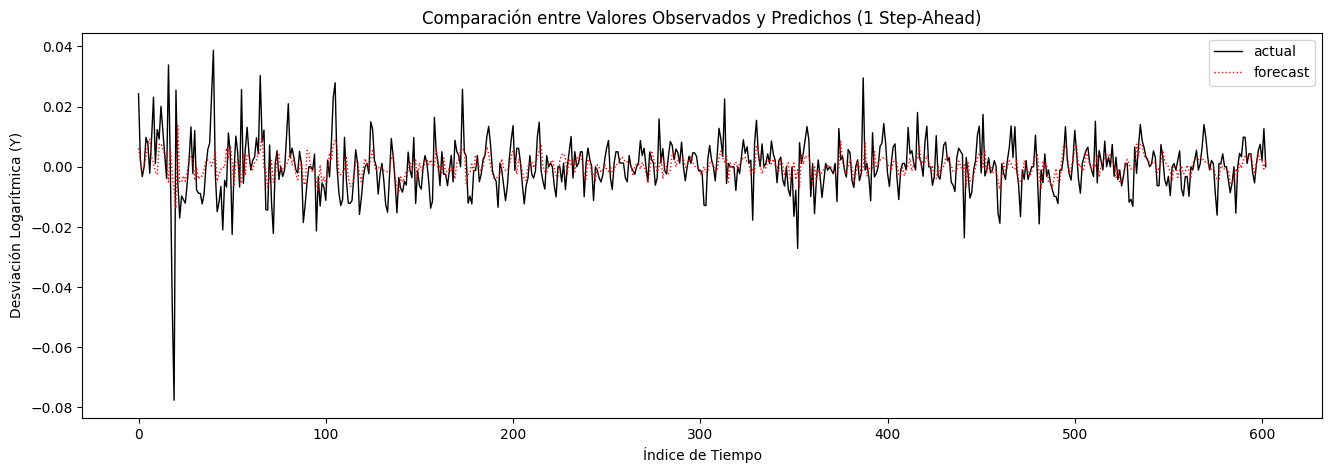

In [54]:
x = range(len(graph_data_1))

plt.figure(figsize=(16, 5))
plt.plot(x, graph_data_1["y"], linestyle='-', color='black', label='actual', linewidth=1.0)
plt.plot(x, graph_data_1["y_pred"], linestyle='dotted', color='r', label='forecast', linewidth=1.0)

plt.title("Comparación entre Valores Observados y Predichos (1 Step-Ahead)")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Desviación Logarítmica (Y)")
plt.legend()
plt.grid(False)
plt.show()


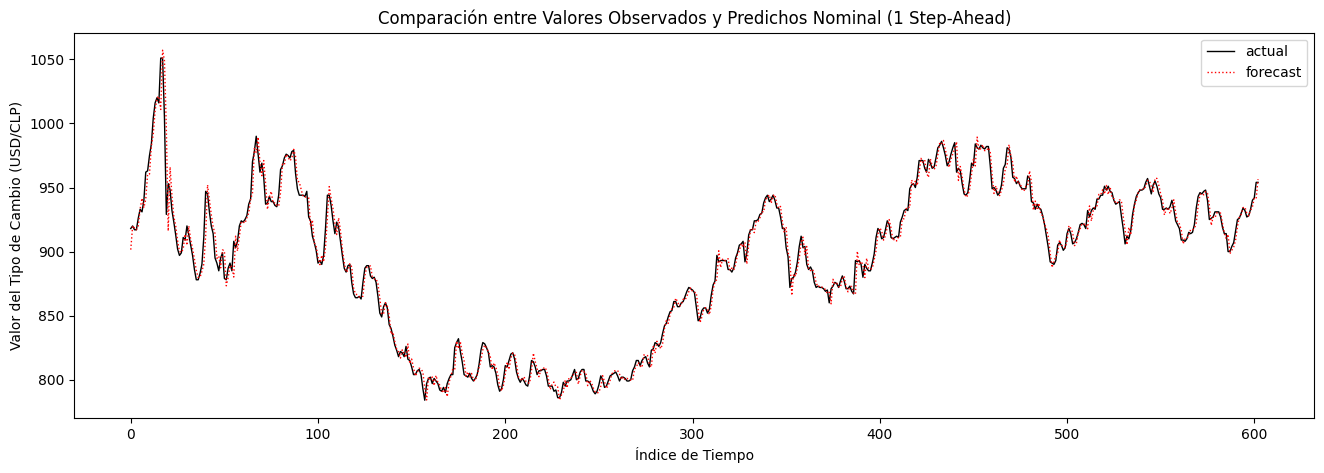

In [55]:
x = range(len(graph_data_1))

plt.figure(figsize=(16, 5))
plt.plot(x, graph_data_1["usd_clp_t"], linestyle='-', color='black', label='actual', linewidth=1.0)
plt.plot(x, graph_data_1["usd_clp_t_pred"], linestyle='dotted', color='r', label='forecast', linewidth=1.0)

plt.title("Comparación entre Valores Observados y Predichos Nominal (1 Step-Ahead)")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor del Tipo de Cambio (USD/CLP)")
plt.legend()
plt.grid(False)
plt.show()

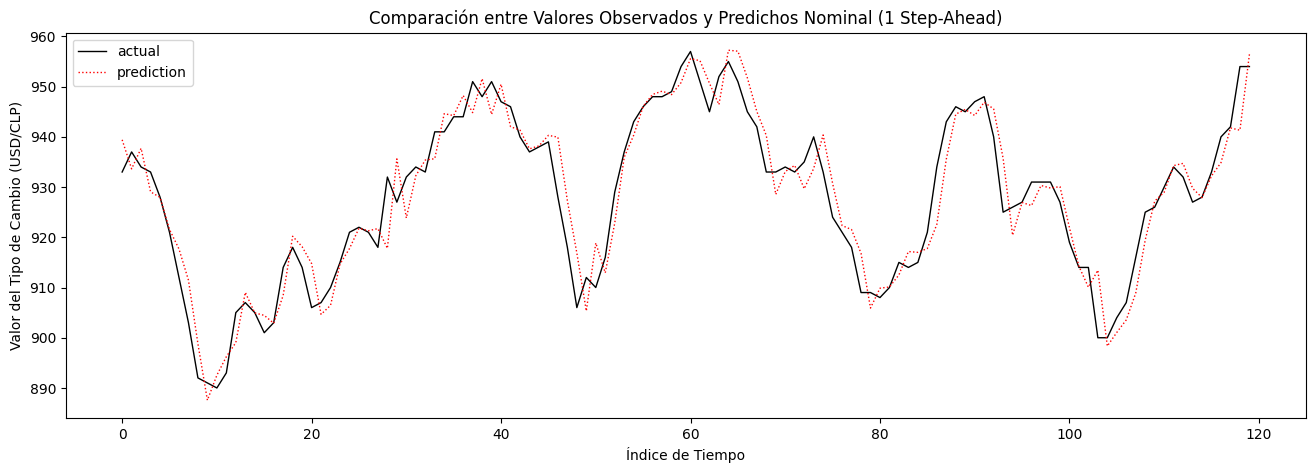

In [56]:
last_data = graph_data_1[-120:]

x = range(len(last_data))

plt.figure(figsize=(16, 5))
plt.plot(x, last_data["usd_clp_t"], linestyle='-', color='black', label='actual', linewidth=1.0)
plt.plot(x, last_data["usd_clp_t_pred"], linestyle='dotted', color='r', label='prediction', linewidth=1.0)

plt.title("Comparación entre Valores Observados y Predichos Nominal (1 Step-Ahead)")
plt.xlabel("Índice de Tiempo")
plt.ylabel("Valor del Tipo de Cambio (USD/CLP)")
plt.legend()
plt.grid(False)
plt.show()

In [57]:
graph_data_1.tail(10)

,update_method,first_windows_ratio,scpecification,first_train_date,last_train_date,step_ahead,y,y_pred,sq_error,usd_clp,usd_clp_t,usd_clp_t_pred,nominal_error
9018,rolling,0.7,"COPPER(2,4)",2019-05-01,2024-10-08,1,0.004310,0.003206,1.218988e-06,926,930.0,928.969009,1.030991
9021,rolling,0.7,"COPPER(2,4)",2019-05-02,2024-10-09,1,0.004292,0.004600,9.497915e-08,930,934.0,934.278036,0.278036
9024,rolling,0.7,"COPPER(2,4)",2019-05-03,2024-10-10,1,-0.002144,0.000772,8.502076e-06,934,932.0,934.721243,2.721243
9027,rolling,0.7,"COPPER(2,4)",2019-05-06,2024-10-11,1,-0.005379,-0.002395,8.906787e-06,932,927.0,929.768023,2.768023
9030,rolling,0.7,"COPPER(2,4)",2019-05-07,2024-10-14,1,0.001078,0.000973,1.104107e-08,927,928.0,927.902055,0.097945
9033,rolling,0.7,"COPPER(2,4)",2019-05-08,2024-10-15,1,0.005373,0.004551,6.756573e-07,928,933.0,932.223777,0.776223
9036,rolling,0.7,"COPPER(2,4)",2019-05-09,2024-10-16,1,0.007475,0.002004,2.992831e-05,933,940.0,934.869729,5.130271
9039,rolling,0.7,"COPPER(2,4)",2019-05-10,2024-10-17,1,0.002125,0.001900,5.066911e-08,940,942.0,941.786283,0.213717
9042,rolling,0.7,"COPPER(2,4)",2019-05-13,2024-10-18,1,0.012658,-0.000721,1.790034e-04,942,954.0,941.320990,12.679010
9045,rolling,0.7,"COPPER(2,4)",2019-05-14,2024-10-21,1,0.000000,0.002547,6.489088e-06,954,954.0,956.430190,2.430190


<Axes: >

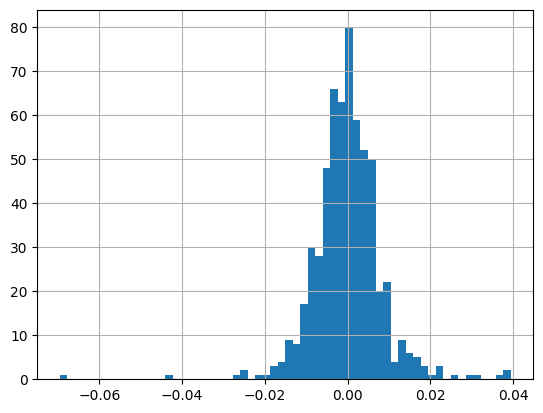

In [58]:
(graph_data_1["y"] - graph_data_1["y_pred"]).hist(bins=60)

<Axes: >

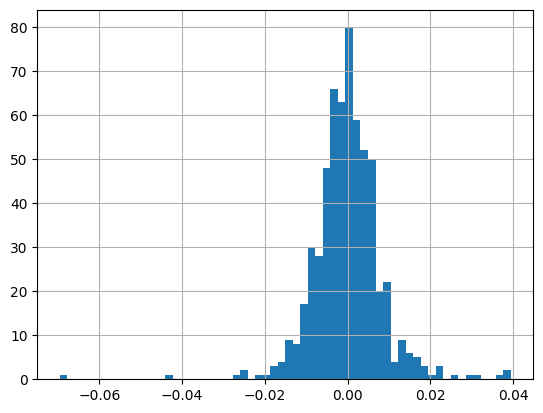

In [38]:
(graph_data_1["y"] - graph_data_1["y_pred"]).hist(bins=60)

### Distribución de Errores Nominales por Horizonte de Predicción

In [41]:
(
    df_results
    .query("update_method == 'rolling' and first_windows_ratio == 0.7 and scpecification == 'COPPER(2,4)'")
    .groupby(["step_ahead"])[["nominal_error"]]
    .describe()
)

nominal_error                                                      \
                   count       mean        std       min       25%       50%   
step_ahead                                                                     
1                  603.0   5.119019   5.777052  0.011309  1.626731  3.650170   
2                  602.0   8.272755   8.725031  0.032550  2.836302  5.870633   
3                  600.0  10.505366  10.595549  0.011120  3.746515  8.053054   

                                   
                  75%         max  
step_ahead                         
1            6.735128   66.857432  
2           11.380736  121.374581  
3           14.362588  125.223335